# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy
from typing import Any, Callable
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=13)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

In [4]:
X_train = pd.read_csv("project-data-merged/df_X_train.csv", index_col=0)
y_train = pd.read_csv("project-data-merged/df_y_train.csv", index_col=0)

X_val = pd.read_csv("project-data-merged/df_X_val.csv", index_col=0)
y_val = pd.read_csv("project-data-merged/df_y_val.csv", index_col=0)

X_test = pd.read_csv("project-data-merged/df_X_test.csv", index_col=0)

In [1]:
display(X_train);

NameError: name 'X_train' is not defined

In [6]:
X_train.replace(['NO','YES'],[False,True],inplace=True)
X_val.replace(['NO','YES'],[False,True],inplace=True)
Sa_T_values = [float(x) for x in X_train.columns[:105]]

# 1. Imputation using Sci-Kit Learn

## 1.1. Create training and testing dataset

First we look how many full rows we have in the training and validation set

In [7]:
full_rows_train = X_train.index[X_train.isnull().any(axis=1) == False].tolist()
full_rows_val = X_val.index[X_val.isnull().any(axis=1) == False].tolist()
full_rows_test = X_test.index[X_test.isnull().any(axis=1) == False].tolist()
#print(full_rows)
print(f'In the TRAINING set; there is: {np.shape(full_rows_train)[0]} full rows, which represents: {np.round(np.shape(full_rows_train)[0]/np.shape(X_train)[0] * 100,2)}% of the training set')
print(f'In the VALIDATING set; there is: {np.shape(full_rows_val)[0]} full rows, which represents: {np.round(np.shape(full_rows_val)[0]/np.shape(X_val)[0] * 100,2)}% of the validating set')
print(f'In TOTAL, we have: {np.shape(full_rows_val)[0] + np.shape(full_rows_val)[0]} full rows, which represents {np.round( (np.shape(full_rows_val)[0] + np.shape(full_rows_val)[0]) / (np.shape(X_train)[0] + np.shape(X_val)[0]) * 100,2)}% of the dataset, excluding the test data')
print(f'In the TESTING set; there is: {np.shape(full_rows_test)[0]} full rows, which represents: {np.round(np.shape(full_rows_test)[0]/np.shape(X_test)[0] * 100,2)}% of the testing set')


#print(f' type(full_rows) = {type(full_rows)}')
#print(f' type(full_rows[0]) = {type(full_rows[0])}')


In the TRAINING set; there is: 3431 full rows, which represents: 2.93% of the training set
In the VALIDATING set; there is: 2512 full rows, which represents: 100.0% of the validating set
In TOTAL, we have: 5024 full rows, which represents 4.2% of the dataset, excluding the test data
In the TESTING set; there is: 48352 full rows, which represents: 100.0% of the testing set


We create a new dataset which merges all the rows of X_train whoes rows are full with the X_val dataset.

In [8]:
#Keep only the rows that are empty
empty_rows = X_train.index.to_list()
for ele in sorted(full_rows_train, reverse = True):
    del empty_rows[ele]

In [9]:
#Values where there is corrupted data, i.e. a value of -999
corrupted_columns = X_train.columns[X_train.eq(-999).any(axis=0) == True].to_list()
corrupted_columns_validate = X_val.columns[X_train.eq(-999).any(axis=0) == True].to_list()

In [10]:
X_data = pd.concat([X_train.iloc[full_rows_train].drop(columns = corrupted_columns), X_val.drop(columns=corrupted_columns_validate)], ignore_index=True)

We then split the new X_train, X_val merged dataset called X_data into two sets, one for training the algorithm and the second one to test it. The rows are first mixed before the splitting.

In [11]:
X_training, X_testing = helpers.create_train_test_dataset_for_regression(X_data,0.95,0.05)

## 1.2. Remove some of the data (as np.nan)

We then need to hide a few values of the testing set in order to validate the model. To do so, first we look how the missing values are disperesed in the original dataset in order to create our own testing set which reflects the same missing values.

### 1.2.1. Check the % of missing values in the raw database

 mean is: 0.2995
 variance is: 0.00474


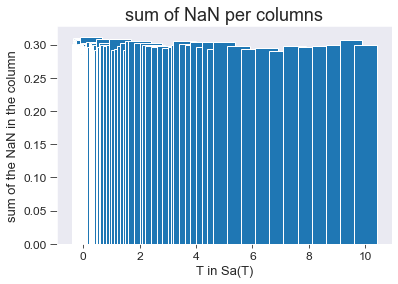

In [12]:
sum_empty = X_train.iloc[empty_rows,:105].isnull().sum(axis=0).to_numpy()/np.shape(X_train.iloc[empty_rows,:105].isnull())[0]
Sa_T_values = [float(x) for x in X_train.columns[:105]]
plt.bar(Sa_T_values, sum_empty)
plt.title('sum of NaN per columns')
plt.xlabel('T in Sa(T)')
plt.ylabel('sum of the NaN in the column')
print(f' mean is: {np.round(np.mean(sum_empty),5)}')
print(f' variance is: {np.round(np.std(sum_empty),5)}')

We see that in average 30% of the data is missing and that the variance is pretty small

### 1.2.2. Remove some values of the testing set

We therefore hide 30% of the dataset while also keeping the original datas to be able to assess the quality of the model

In [13]:
X_testing_original, X_testing_missing_values = helpers.hide_values_SaT(X_testing)

 mean is: 0.2906
 variance is: 0.02745


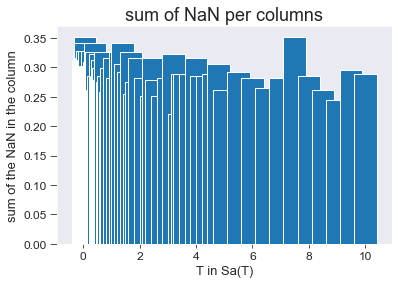

In [14]:
X_testing_original, X_testing_missing_values = helpers.hide_values_SaT(X_testing)

sum_empty = X_testing_missing_values.iloc[:,:105].isnull().sum(axis=0).to_numpy()/np.shape(X_testing_missing_values.iloc[:,:105])[0]
plt.bar(Sa_T_values, sum_empty[:105])
plt.title('sum of NaN per columns')
plt.xlabel('T in Sa(T)')
plt.ylabel('sum of the NaN in the column')
print(f' mean is: {np.round(np.mean(sum_empty),5)}')
print(f' variance is: {np.round(np.std(sum_empty),5)}')

Sanity check, in red the missing values 

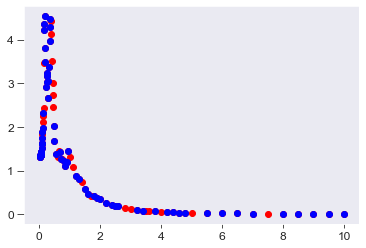

In [15]:
plt.scatter(Sa_T_values,X_testing_original.iloc[10,:105],color='r')
plt.scatter(Sa_T_values,X_testing_missing_values.iloc[10,:105],color='b')

## 1.3. Training the model and guessing the missing values

### 1.3.1. Imports for sci-kit learn

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

Normalize the training set 

In [17]:
X_training.iloc[:,:105] = (X_training.iloc[:,:105]-X_training.iloc[:,:105].mean())/X_training.iloc[:,:105].std()

### 1.3.2 method = KNNRegressor

Try the `KNearestNeigbhour` imputation method for several different values of `K`.

In [ ]:
K_value = 35
estimations, score = helpers.KNNReg_K_finder(training=X_training, missing=X_testing_missing_values, original=X_testing_original, K=K_value)

  9%|███████                                                                            | 3/35 [00:08<01:26,  2.71s/it]

Evolution of the score (evaluated using the mean square root error, MSRE) with respect to the values of `K`. The higher the score, the worst is the model.

In [ ]:
plt.plot(range(2,K_value+1),score,marker='o', markersize=7)
plt.suptitle('Score in with resepect to K', y=1.05, fontsize=25)
plt.title('The higher the score, the less good is the method', fontsize=15)
plt.xlabel('K')
plt.ylabel('score (MSRE)')

Example of a curve being fitted by the model with `K=2`. 

In [ ]:
curve_nbr = 250
fig1 = plt.figure()
plt.plot(Sa_T_values, estimations[0,curve_nbr,:105],color='blue',alpha=0.5,label='K=2')
plt.plot(Sa_T_values, X_testing_original.iloc[curve_nbr,:105], color='black', label='original')
plt.xlim(0,1)
plt.legend()

We see that the score seems pretty high compared to the classical interpolation methods (see section #2). 

### 1.3.3. method = BayesianRidge

In [ ]:
imp = IterativeImputer(estimator = BayesianRidge(), max_iter=25)
#X_training.iloc[:,:105] = (X_training.iloc[:,:105]-X_training.iloc[:,:105].mean())/X_training.iloc[:,:105].std()
imp.fit(X_training)
estim_BR = imp.transform(X_testing_missing_values)

score_BR = helpers.score_estimation(X_testing_original.iloc[:,:105].to_numpy(), estim_BR[:,:105])
print(f'score_BR = {score_BR}')

The score is even higher using this method. 

# 2. Interpolation using df.interpolate()

This section studies the results when we use a simpler method: interpolation.

## 2.1. Trying different methods

We compare several interpolation methods, namely:
`linear`, `values`, `quadratic`, `cubic`, `piecewise_polynomial`, `spline` and `cubicspline`. 

First, we recreate a testing set but this time there is no training set needed. Hence we simply take all the values of the dataset X_data and hide 30% of each rows.

In [ ]:
X_interp_train, X_interp_testing = helpers.create_train_test_dataset_for_regression(X_data,0.0,1.0)

X_interp_original, X_interp_missing = helpers.hide_values_SaT(X_interp_testing)

X_interp_missing = X_interp_missing.iloc[:,:105]
X_interp_missing.columns = Sa_T_values

We then test the different methods. 

In [ ]:
X_interp_lin = X_interp_missing.copy(deep=True)
X_interp_lin = X_interp_missing.interpolate(method='linear', axis = 1, limit_direction='both')

X_interp_quad = X_interp_missing.copy(deep=True)

X_interp_quad = X_interp_missing.interpolate(method='quadratic', axis = 1, limit_direction='both')
X_interp_quad = X_interp_quad.fillna(method = 'bfill',axis=1)
X_interp_quad = X_interp_quad.fillna(method = 'ffill',axis=1)

X_interp_cub = X_interp_missing.copy(deep=True)
X_interp_cub = X_interp_missing.interpolate(method='cubic', axis = 1, limit_direction='both')
X_interp_cub = X_interp_cub.fillna(method = 'bfill',axis=1)
X_interp_cub = X_interp_cub.fillna(method = 'ffill',axis=1)

X_interp_ppl = X_interp_missing.copy(deep=True)
X_interp_ppl = X_interp_missing.interpolate(method='piecewise_polynomial', axis = 1, limit_direction='both')
X_interp_ppl = X_interp_ppl.fillna(method = 'bfill',axis=1)
X_interp_ppl = X_interp_ppl.fillna(method = 'ffill',axis=1)

X_interp_spl = X_interp_missing.copy(deep=True)
X_interp_spl = X_interp_missing.interpolate(method='spline', order=2, axis = 1, limit_direction='both')

X_interp_cubspl = X_interp_missing.copy(deep=True)
X_interp_cubspl = X_interp_missing.interpolate(method='cubicspline', axis = 1, limit_direction='both')

And compute it's score using MSRE.

In [ ]:
score_lin = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_lin.to_numpy())
score_quad = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_quad.to_numpy())
score_cub = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_cub.to_numpy())
score_ppl = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_ppl.to_numpy())
score_spl = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_spl.to_numpy())
score_cubspl = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_cubspl.to_numpy())
print(f' score_lin = {score_lin} \n score_quad = {score_quad} \n score_cub = {score_cub}')
print(f' score_ppl = {score_ppl} \n score_spl = {score_spl} \n score_cubspl = {score_cubspl}')

In [ ]:
fig1=plt.figure(1)
plt.title('Score depending on the method used')
plt.scatter(1,score_lin,color='b',marker='o',s=50,label='1-linear')
plt.scatter(2,score_quad,color='b',marker='o',s=50,label='2-quadratic')
plt.scatter(3,score_cub,color='b',marker='o',s=50,label='3-quadratic')
plt.scatter(4,score_ppl,color='b',marker='o',s=50,label='4-piecewise_polynomial')
plt.scatter(5,score_spl,color='b',marker='o',s=50,label='5-spline')
plt.scatter(6,score_cubspl,color='b',marker='o',s=50,label='6-cubic_spline')
plt.ylim(0,20)
plt.xlabel('Method used')
plt.ylabel('Score (MSRE)')
plt.legend(loc='upper left')

In [ ]:
curve_nbr=250
fig1 = plt.figure()
plt.plot(Sa_T_values, X_interp_lin.iloc[curve_nbr,:105], color='blue', alpha = 0.5, label='linear')
plt.plot(Sa_T_values, X_interp_quad.iloc[curve_nbr,:105], color='green', alpha = 0.5, label='quadratic')
plt.plot(Sa_T_values, X_interp_cub.iloc[curve_nbr,:105], color='red', alpha = 0.5, label='cubic')
plt.plot(Sa_T_values, X_interp_ppl.iloc[curve_nbr,:105], color='magenta', alpha = 0.5, label='piecewise-poly')
plt.semilogx(Sa_T_values, X_interp_original.iloc[curve_nbr,:105], color='black', alpha = 1, label='original')
#plt.xlim(0,1)
plt.legend()

We intuiively see that the `linear`, `quadratic` and `piecewise_polynomial` methods performs the better. Nonetheless, we need to iterate several times and average to be able to assessexactly which methods works best.

## 2.2. Looping for more precision

In [ ]:
Score_lin = np.ndarray(0)
Score_quad = np.ndarray(0)
Score_cub = np.ndarray(0)
Score_ppl = np.ndarray(0)
Score_spl = np.ndarray(0)
Score_cubspl = np.ndarray(0)
iterations = 30

In [ ]:
for i in tqdm(range(0,iterations)):
    #Prepare the original and missing datas:
    X_interp_train, X_interp_testing = helpers.create_train_test_dataset_for_regression(X_data,0.0,1.0)

    X_interp_original, X_interp_missing = helpers.hide_values_SaT(X_interp_testing)

    X_interp_missing = X_interp_missing.iloc[:,:105]
    X_interp_missing.columns = Sa_T_values

    #Start interpolating and evaluating
    X_interp_lin = X_interp_missing.copy(deep=True)
    X_interp_lin = X_interp_missing.interpolate(method='linear', axis = 1, limit_direction='both')

    X_interp_quad = X_interp_missing.copy(deep=True)

    X_interp_quad = X_interp_missing.interpolate(method='quadratic', axis = 1, limit_direction='both')
    X_interp_quad = X_interp_quad.fillna(method = 'bfill',axis=1)
    X_interp_quad = X_interp_quad.fillna(method = 'ffill',axis=1)

    X_interp_cub = X_interp_missing.copy(deep=True)
    X_interp_cub = X_interp_missing.interpolate(method='cubic', axis = 1, limit_direction='both')
    X_interp_cub = X_interp_cub.fillna(method = 'bfill',axis=1)
    X_interp_cub = X_interp_cub.fillna(method = 'ffill',axis=1)

    X_interp_ppl = X_interp_missing.copy(deep=True)
    X_interp_ppl = X_interp_missing.interpolate(method='piecewise_polynomial', axis = 1, limit_direction='both')
    X_interp_ppl = X_interp_ppl.fillna(method = 'bfill',axis=1)
    X_interp_ppl = X_interp_ppl.fillna(method = 'ffill',axis=1)

    X_interp_spl = X_interp_missing.copy(deep=True)
    X_interp_spl = X_interp_missing.interpolate(method='spline', order=2, axis = 1, limit_direction='both')

    X_interp_cubspl = X_interp_missing.copy(deep=True)
    X_interp_cubspl = X_interp_missing.interpolate(method='cubicspline', axis = 1, limit_direction='both')

    score_lin = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_lin.to_numpy())
    score_quad = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_quad.to_numpy())
    score_cub = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_cub.to_numpy())
    score_ppl = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_ppl.to_numpy())
    score_spl = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_spl.to_numpy())
    score_cubspl = helpers.score_estimation(original=X_interp_original.iloc[:,:105].to_numpy(), estimated=X_interp_cubspl.to_numpy())
    
    Score_lin = np.append(Score_lin,score_lin)
    Score_quad = np.append(Score_quad,score_quad)
    Score_cub = np.append(Score_cub,score_cub)
    Score_ppl = np.append(Score_ppl,score_ppl)
    Score_spl = np.append(Score_spl,score_spl)
    Score_cubspl = np.append(Score_cubspl,score_cubspl)

In [ ]:
print('MSR ERROR:')
print(f' score_lin = {np.mean(Score_lin)} \n score_quad = {np.mean(Score_quad)} \n score_cub = {np.mean(Score_cub)}')
print(f' score_ppl = {np.mean(Score_ppl)} \n score_spl = {np.mean(Score_spl)} \n score_cubspl = {np.mean(Score_cubspl)}')
fig3 = plt.figure(3)
plt.title('Mean Square Root Error')
plt.plot(range(0,iterations), Score_lin, color='b',label='linear')
plt.plot(range(0,iterations), Score_quad, color='r',label='quad')
plt.plot(range(0,iterations), Score_cub, color='green',label='cub')
plt.plot(range(0,iterations), Score_ppl, color='magenta',label='ppl')
plt.plot(range(0,iterations), Score_spl, color='yellow',label='spl')
plt.plot(range(0,iterations), Score_cubspl, color='purple',label='cubspl')
plt.xlabel('iteration')
plt.ylabel('MSRE')
plt.legend()
plt.ylim(0,1.5)
plt.xlim(0,iterations-1)

We see that in general the `quadratic` method works the best and gives the best results, even though it has a higher variance. The second best choice would be the `linear` method as it is more robust, but the error is in average higher. 

# 3. Conclusion and exports

We saw that the method having the smallest error is quadratic interpolation and then back and forth filling for the NaNs at the edges. 

Hence we will re-import all files, interpolate the missing data in X_train and export them.  

Sanity check:

Work done, no more NaNs in the training set. We can export the data.